# FoolboxをつかったAdversarial Examples

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical

import model_make as mm

Using TensorFlow backend.


In [2]:
import foolbox
from foolbox.models import KerasModel

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 255.
x_test = x_test.reshape(-1, 28, 28, 1) / 255.
# y_train = to_categorical(y_train, 10)
# y_test = to_categorical(y_test, 10)

In [4]:
# 攻撃対象のCNNの保存先 or 読み込み先
model_path = Path("..", "model_dir")
model_path.mkdir(exist_ok=True)
model_path /= "CNN.h5"

# 学習済みのCNNがあればロード、なければ作成
if model_path.exists():
    model = load_model(str(model_path))
else:
    log_dir = Path('..', 'logs')
    model = mm.CNN(input_shape=(28, 28, 1)) # MNIST用
    tb = TensorBoard(log_dir=str(log_dir))
    model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
    model.fit(x=x_train, y=y_train, epochs=5, validation_data=(x_test, y_test), callbacks=[tb])
    model.save(str(model_path))

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
fmodel = foolbox.models.TensorFlowModel.from_keras(model, bounds=(0, 255))

In [6]:
attack_criterion = foolbox.criteria.Misclassification()
distance = foolbox.distances.Linfinity # 摂動距離 L-∞ norm

In [7]:
attack = foolbox.attacks.FGSM(fmodel, criterion=attack_criterion, distance=distance)

In [8]:
idx = 0
x_adv = attack(input_or_adv=x_test[idx], label=y_test[idx], unpack=False)

/home/takubuntu/.pyenv/versions/anaconda3-4.4.0/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


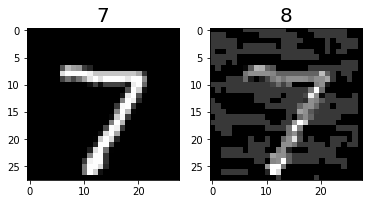

In [9]:
fig = plt.figure(figsize=(6, 12))

for i in range(2):
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(x_test[idx]), cmap='gray')
    plt.title(np.argmax(model.predict(x_test[idx].reshape(-1, 28, 28, 1))), fontsize=20) # 通常画像の結果
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(x_adv.image), cmap='gray')
    plt.title(np.argmax(model.predict(x_adv.image.reshape(-1, 28, 28, 1))), fontsize=20)